# Dự báo VN-Index bằng Long Short-Term Memory (LSTM Model)

Các nghiên cứu thực nghiệm áp dụng cho nhiều chuỗi dữ liệu thời gian (Time Series) đã chứng tỏ rằng Long Short-Term Memory (LSTM) hiệu quả hơn các cách tiếp cận của thống kê truyền thống như ARIMA, GARCH.. cho bài toán dự báo do cách tiếp cận này "học hỏi" tốt hơn từ quá khứ. Cái tên của mô hình dịch ra nghĩa đen đã phần nào thể hiện bản chất *học hỏi từ quá khứ* của cách tiếp cận này: **trí nhớ ngắn hạn và dài hạn**. Post này hướng dẫn ngắn gọn kiểu hands-on cho dự báo chỉ số VN-Index với dữ liệu lấy từ https://www.vndirect.com.vn/  trong đó biến trễ 1 của open được sử dụng để dự báo giá hiện thời của open. Nói cách khác, chúng ta đang sử dụng dữ liệu quá khứ (trễ 1 ngày) để *dự báo VN-Index hiện tại*. 

In [1]:
# Import data (Download từ http://www.mediafire.com/file/d4ur1rlo895m6mr/vnindex.csv/file): 
import pandas as pd
import numpy as np
exchange_data = pd.read_csv("C:/Users/Zbook/Desktop/deeplearningFinance/vnindex.csv")

In [2]:
# Chuẩn bị dữ liệu: 

exchange_data["date"] = pd.to_datetime(exchange_data["date"])
ind_exchange_data = exchange_data.set_index(["date"], drop=True)

data_frame = ind_exchange_data.sort_index(axis=1, ascending=True)
data_frame = data_frame.iloc[::-1]

# Lấy VN-Index lúc mở cửa: 
df = data_frame[["open"]]

# Lấy dữ liệu trước ngày 01 - 01 - 2017 để huấn luyện mô hình: 

split_date = pd.Timestamp('01-01-2017')
train = df.loc[:split_date]
test = df.loc[split_date:]

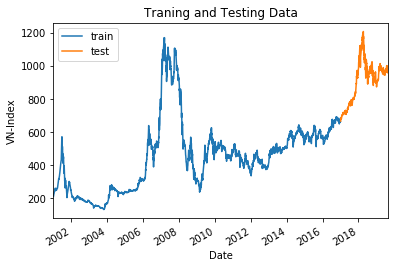

In [3]:
# Phần dữ liệu "màu xanh" sử dụng để train LSTM. Các dự báo thu được từ 
# LSTM sẽ được đối chiếu lại với phần dữ liệu "màu vàng" - tức là VN-Index
# từ 02 - 01 - 2017 cho đến 04 - 09 - 2019: 

%matplotlib inline
import matplotlib.pyplot as plt

ax = train.plot()
test.plot(ax=ax)
plt.title("Traning and Testing Data")
plt.xlabel('Date')
plt.ylabel('VN-Index')
plt.legend(['train', 'test'])

In [19]:
# Preprocessing Data cho huấn luyện LSTM: 
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

# VN-Index hiện thời: 
y_train = train_sc[1:] # Bỏ quan sát đầu tiên. 
y_test = test_sc[1:]

# Lấy lag1 (tức trễ 1 của open) tương ứng cho train và test data: 
X_train = train_sc[:-1] # Bỏ quan sát cuối cùng. 
X_test = test_sc[:-1] 

# Chuẩn bị dữ liệu cho huấn luyện LSTM: 
X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [20]:
# Xây dựng kiến trúc cho LSTM: 
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM
from numpy.random import seed
from tensorflow import set_random_seed

K.clear_session()

my_seeds = 29
seed(my_seeds)
set_random_seed(my_seeds)

early_stop = EarlyStopping(monitor='loss', patience=5)

model_lstm = Sequential()
model_lstm.add(LSTM(units = 50, input_shape=(1, X_train.shape[1]), activation='relu', 
                    kernel_initializer='lecun_uniform', return_sequences=False))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')

In [21]:
# Huấn luyện mô hình đồng thời tính thời gian huấn luyện: 
import time
start_time = time.time()

history = model_lstm.fit(X_tr_t, y_train, epochs=20, batch_size=35, verbose=0, 
                         shuffle=False, validation_split=0.2, callbacks=[early_stop])

print('Training Time:', time.time() - start_time)

Training Time: 13.009884595870972


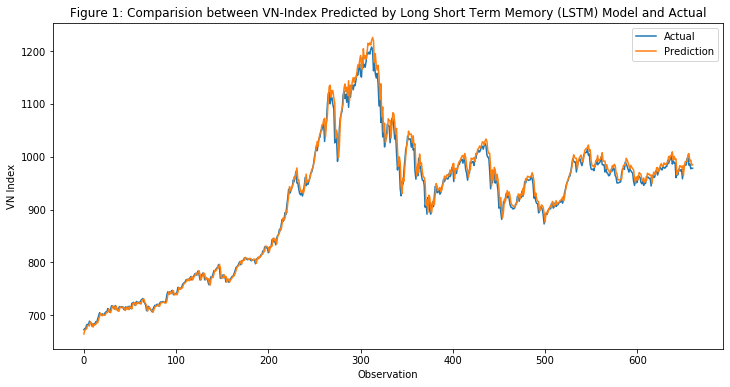

In [22]:
# Sử dụng LSTM cho dự báo: 
y_pred_test_LSTM = model_lstm.predict(X_tst_t)

# Convert các giá trị dự báo - kiểm định về nguyên dạng ban đầu: 
y_pred_test_LSTM = sc.inverse_transform(y_pred_test_LSTM)
y_test = sc.inverse_transform(y_test)

# So sánh giá trị dự báo với giá trị thực tế của VN-Index: 
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred_test_LSTM, label='Prediction')
plt.title("Figure 1: Comparision between VN-Index Predicted by Long Short Term Memory (LSTM) Model and Actual")
plt.xlabel('Observation')
plt.ylabel('VN Index')
plt.legend()

Viết hàm tính toán một số tiêu chí đánh giá chất lượng dự báo cho Time Series như MAE, MAPE và Theil's U: 

In [23]:
def performance(actual, predicted): 
    
    # Tính MAE: 
    deviation = actual - predicted
    mae = sum(abs(deviation)) / len(deviation)
    
    # Tính MAPE: 
    deviation_abs_frac = 100*abs(deviation) / actual
    mape = sum(deviation_abs_frac) / len(deviation_abs_frac)

    # Tính Theil'U: 
    ts = sum(deviation*deviation) / len(deviation)
    ts = np.sqrt(ts)
    
    com1 = np.sqrt(sum(actual*actual) / len(actual))
    com2 = np.sqrt(sum(predicted*predicted) / len(predicted))
    u = ts / (com1 + com2)
    
    df = {"MAE": mae, "MAPE": mape, "U": u}
    df_results = pd.DataFrame(df)
    return df_results

# Sử dụng hàm đã có: 
performance(y_test, y_pred_test_LSTM)

,MAE,MAPE,U
0,9.020964,0.947066,0.007314


Giá trị của U (Theil's U) sẽ nằm giữa 0 và 1. Nếu U càng bé thì chất lượng dự báo của mô hình càng tốt. MAPE = 0.947 có nghĩa là giá trị dự báo của VN-Index sai lệch cộng/trừ 0.947% (hay sai số chưa đến 1%). 

# Vài kết luận

- LSTM là một cách tiếp cận hữu hiệu cho dự báo và nhiều nghiên cứu thực nghiệm đã chỉ ra rằng LSTM hiệu quả hơn các cách tiếp cận của thống kê truyền thống như (ARIMA, GARCH..) áp dụng cho Time Series. 

- Các tham số của mô hình LSTM ở trên đã được tinh chỉnh và tối ưu. Cách thức tinh chỉnh LSTM sẽ được trình bày trong một post khác. 


# Tài liệu tham khảo
1. De Prado, M. L. (2018). Advances in financial machine learning. John Wiley & Sons.
2. Hilpisch, Y. (2018). Python for Finance: Mastering Data-driven Finance. O'Reilly Media.
3. Gers, F. A., Eck, D., & Schmidhuber, J. (2002). Applying LSTM to time series predictable through time-window approaches. In Neural Nets WIRN Vietri-01 (pp. 193-200). Springer, London.
4. Nelson, D. M., Pereira, A. C., & de Oliveira, R. A. (2017, May). Stock market's price movement prediction with LSTM neural networks. In 2017 International Joint Conference on Neural Networks (IJCNN) (pp. 1419-1426). IEEE.
5. Fischer, T., & Krauss, C. (2018). Deep learning with long short-term memory networks for financial market predictions. European Journal of Operational Research, 270(2), 654-669.
6. Roondiwala, M., Patel, H., & Varma, S. (2017). Predicting stock prices using LSTM. International Journal of Science and Research (IJSR), 6(4), 1754-1756.